# Why scaling method matters for scRNA-Seq integration

Author: Iwo Kucinski (https://github.com/Iwo-K/)

Scaling (or zero-centering) of variables is a common pre-processing step of scRNA-Seq analysis. However, it requires some caution when combining datasets. This is because after scaling the relative expression is dependent on other cells present in the dataset. Hence, working with datasets pre-scaled separately is risky, particularly when datasets have different cell type compositions, and has a potential to cause large errors when integrating a small dataset into a larger reference landscape.

In this notebook, we will present a simple (and exaggerated) illustration of this problem and consider the potential ramifications and solutions.

## Setup

In [37]:
from anndata import AnnData
import numpy as np
import scanpy as sc
import pandas as pd
import cellproject as cp

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Scaling problem illustration

### Data

We will prepare datasets for two celltypes (hsc and meg) across two batches (hsc1 and hsc2/meg2) to illustrate the problem:

- hsc1 and hsc2, 10 cells each with 100 normally distributed genes (same mean)
- meg2, 10 cells with 50 genes with higher expression (Meg genes) and 50 genes with expression the same mean as in hsc1 and hsc2
- hsc2 and meg2 are combined into a single batch hscmeg2

In [39]:
#Generating simple data:
hsc1 = AnnData(np.random.normal(10, 0.5, (10,100)),
             obs = pd.DataFrame({'celltype' : ['hsc1']*10}, index = ['hsc1_' + str(i) for i in range(10)]) ,
             var = pd.DataFrame(index = ['Meggene' + str(i) for i in range(50)] + ['stable' + str(i) for i in range(50)]))

hsc2 = AnnData(np.random.normal(10, 0.5, (10,100)),
             obs = pd.DataFrame({'celltype' : ['hsc2']*10}, index = ['hsc2_' + str(i) for i in range(10)]) ,
             var = pd.DataFrame(index = ['Meggene' + str(i) for i in range(50)] + ['stable' + str(i) for i in range(50)]))

meg2 = AnnData(np.concatenate((np.random.normal(40, 0.5, (10,50)), np.random.normal(10, 0.5, (10,50))), axis = 1),
             obs = pd.DataFrame({'celltype' : ['meg2']*10}, index = ['meg2_' + str(i) for i in range(10)]) ,
             var = pd.DataFrame(index = ['Meggene' + str(i) for i in range(50)] + ['stable' + str(i) for i in range(50)]))

hscmeg2 = hsc2.concatenate(meg2)

### Scaling combined data

If we combine the two batches and scale them together we obtain exactly what is expected, hsc1 and hsc2 overlapping while meg2 population separated along PC1.

... storing 'celltype' as categorical


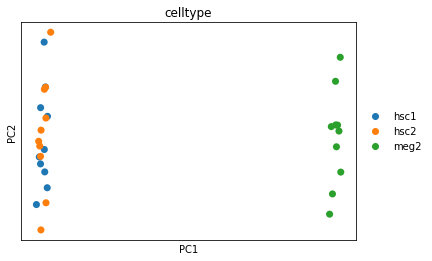

In [40]:
#Calculating common PCA
comb = hsc1.concatenate(hscmeg2)
comb_scaled_together = sc.pp.scale(comb, copy = True)
sc.tl.pca(comb_scaled_together, n_comps = 5)
sc.pl.pca(comb_scaled_together, color = 'celltype', size = 200)

### Scaling data separately

If data is scaled separately, hsc1 population ends up in between hsc2 and meg2. This is because, in hsc1 cells the 'meg genes' have a mean close to 0, whereas the same genes in hsc2 cells have strongly negative values.

... storing 'celltype' as categorical


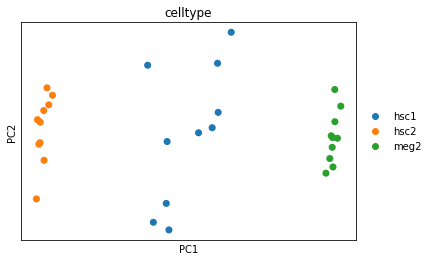

In [41]:
#Calculating common PCA
hsc1_scaled = sc.pp.scale(hsc1, copy = True)
hscmeg2_scaled = sc.pp.scale(hscmeg2, copy = True)
comb_scaled_separately = hsc1_scaled.concatenate(hscmeg2_scaled)
sc.tl.pca(comb_scaled_separately, n_comps = 5)
sc.pl.pca(comb_scaled_separately, color = 'celltype', size = 200)

## Real problems and solutions

Based on the example above there are two practical problems:

1. Merging two separately scaled datasets is generally not a good idea. This is easily solved by just combinind log-normalised data first (or by matching the scaling parameters for the new dataste, see below).

2. Scanpy by default zero-centers variables for the PCA calculation (regardless of prior scaling), which means that fitting new data into an existing (reference) PCA space should take into account expression means of the reference data. The `scanpy.tl.ingest` function does not account for the scaling problem.

As exemplied below, the ingest-corrected data, even run on correctly scaled data, shows separation between hsc1 and hsc2.

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


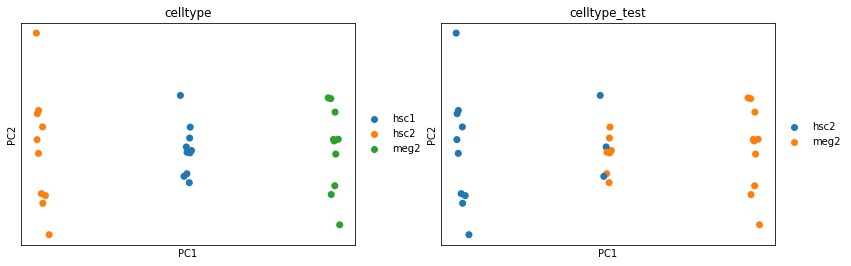

In [42]:
hsc1_commonscale = comb_scaled_together[comb_scaled_together.obs.index[comb_scaled_together.obs.celltype == 'hsc1'],:]
hscmeg2_commonscale = comb_scaled_together[comb_scaled_together.obs.index[comb_scaled_together.obs.celltype != 'hsc1'],:]

hscmeg2_commonscale.obs['celltype_test'] = hscmeg2_commonscale.obs['celltype'].copy()
sc.tl.pca(hscmeg2_commonscale, n_comps = 5)
sc.pp.neighbors(hscmeg2_commonscale)
sc.tl.ingest(hsc1_commonscale, hscmeg2_commonscale, obs='celltype_test', embedding_method='pca')

ingested_commonscale = hsc1_commonscale.concatenate(hscmeg2_commonscale)
sc.pl.pca(ingested_commonscale, color = ['celltype', 'celltype_test'], size = 200)

This behaviour can be avoided by using the mean (and standard deviation) of the reference data to scale the projected data accordingly. PCA fitting in Cellproject takes this into account. Additionally cellproject can match scaling of the reference data so we we can supply scaled hsc2/meg2 data and un-scaled hsc1 values and set `scale_data=True`.

... storing 'celltype' as categorical
... storing 'ref_celltype' as categorical


Running a common scaling for target and reference data
Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
No valid UMAP object provided, UMAP parameters left unmodified


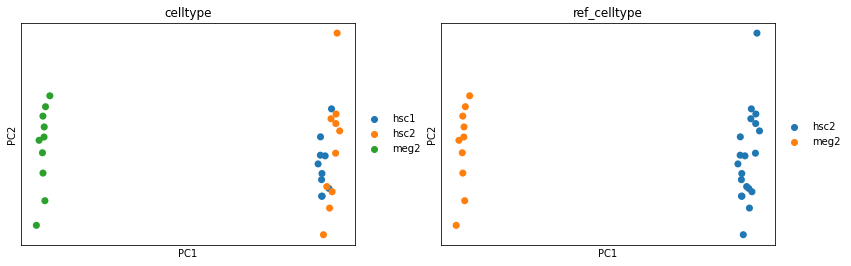

In [43]:
sc.tl.pca(hscmeg2_scaled, n_comps = 5)

cp.project_cells(hsc1, 
                 hscmeg2_scaled,
                 k = 3,
                 obs_columns = ['celltype'],
                 scale_data = True,
                 use_vargenes = False)
hscmeg2_scaled.obs['ref_celltype'] = hscmeg2_scaled.obs['celltype'].copy()

comb = hsc1.concatenate(hscmeg2_scaled)
sc.pl.pca(comb, color = ['celltype', 'ref_celltype'], size = 200)

Once we take the scaling into account the two datasets behave as expected.